# Sparse Autoencoder
Build a sparse autoencoder to work on fashion-MNIST data set. "Hands-On Machine Learning", by Aurelien Geron, is the basis for much of the code. https://github.com/ageron/handson-ml2

In [1]:
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorboard

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

%matplotlib inline

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


Left align tables:

In [2]:
%%html
<style>
table {float:left}
</style>

## 1.0 Load and Prepare Data

In [3]:
# load fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all, y_train_all), (X_test, y_test) = fashion_mnist.load_data()

In [4]:
# check the shape of the data sets
print('X_train_full shape:', X_train_all.shape)
print('y_train_full shape:', y_train_all.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train_full shape: (60000, 28, 28)
y_train_full shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [5]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [6]:
# split the data between train and validation sets, and scale

X_valid, X_train = X_train_all[:5000] / 255.0, X_train_all[5000:] / 255.0
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# also scale the X_test
X_test = X_test / 255.0

print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_valid shape: (5000, 28, 28)
y_valid shape: (5000,)
X_train shape: (55000, 28, 28)
y_train shape: (55000,)


## 2.0 Sparse Autoencoder

We will build as sparse autoencoder. But first, we will build a vanilla stacked autoencoder as a comparison.

Andrew Ng has a good video of what a sparse autoencoder is: https://youtu.be/vfnxKO2rMq4

In [7]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

Note: we are using sigmoid activations so that the activations all end up between 0 and 1. This will make visualizing the activations easier.

In [8]:
tf.random.set_seed(42)
np.random.seed(42)

simple_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="sigmoid"),
])
simple_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
simple_ae = keras.models.Sequential([simple_encoder, simple_decoder])
simple_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.),
                  metrics=[rounded_accuracy])
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.4336 - rounded_accuracy: 0.7943 - val_loss: 0.3728 - val_rounded_accuracy: 0.8526
Epoch 2/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3617 - rounded_accuracy: 0.8668 - val_loss: 0.3471 - val_rounded_accuracy: 0.8784
Epoch 3/10
55000/55000 [==============================] - 4s 74us/sample - loss: 0.3405 - rounded_accuracy: 0.8862 - val_loss: 0.3313 - val_rounded_accuracy: 0.8892
Epoch 4/10
55000/55000 [==============================] - 4s 73us/sample - loss: 0.3277 - rounded_accuracy: 0.8967 - val_loss: 0.3210 - val_rounded_accuracy: 0.8989
Epoch 5/10
55000/55000 [==============================] - 4s 72us/sample - loss: 0.3214 - rounded_accuracy: 0.9013 - val_loss: 0.3173 - val_rounded_accuracy: 0.9033
Epoch 6/10
55000/55000 [==============================] - 4s 75us/sample - loss: 0.3182 - rounded_accuracy: 0.9037 - val_loss:

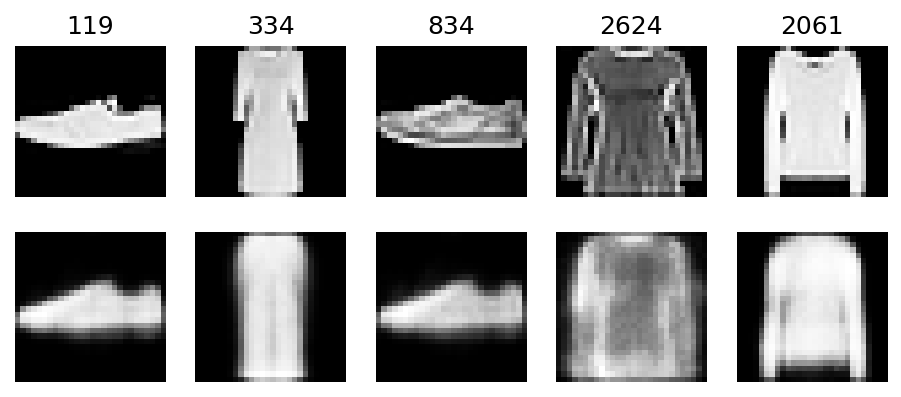

In [9]:
# plot the results
def plot_reconstructions(model, index_list, X_valid): 
    reconstructions = model.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(2, n_images,figsize=(n_images*1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        
    plt.show()

import random
index_list = random.sample(range(0,len(X_valid)), 5)
plot_reconstructions(simple_ae, index_list, X_valid)

We want to see how the activations behave with this simple stacked autoencoder.
- Using the validation data set, **what is the distribution of activations between 0 and 1?**
- Using the validation data set, **what are the average neuron activation values?**

In [10]:
# plots from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])


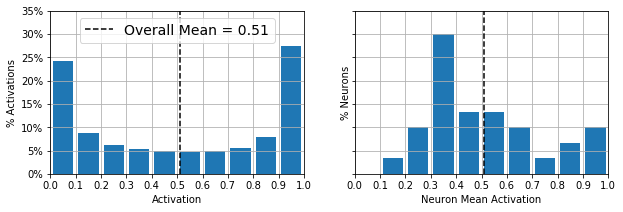

In [21]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

The above plots show that there are activations all over the map (from 0 to 1) when we put all the validation data through the encoder.
- Left plot: About 23% of the activations have a value of 0 (when we give the encoder all the validation data). About 27% have a value of 1.
- Right plot: Distribution of the mean activation per neuron. Mean activation per neuron is around 0.5. However, there is a percentage of neurons that fire almost all the time (as demonstrated by the 1.0)

We'll add L1 (lasso) regularization. (future work: describe what L1 regularization is)

In [22]:
tf.random.set_seed(16)
np.random.seed(16)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])



Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 88us/sample - loss: 0.4304 - rounded_accuracy: 0.8158 - val_loss: 0.3751 - val_rounded_accuracy: 0.8638
Epoch 2/10
55000/55000 [==============================] - 4s 79us/sample - loss: 0.3691 - rounded_accuracy: 0.8696 - val_loss: 0.3590 - val_rounded_accuracy: 0.8756
Epoch 3/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3546 - rounded_accuracy: 0.8802 - val_loss: 0.3514 - val_rounded_accuracy: 0.8734
Epoch 4/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3439 - rounded_accuracy: 0.8879 - val_loss: 0.3379 - val_rounded_accuracy: 0.8891
Epoch 5/10
55000/55000 [==============================] - 4s 78us/sample - loss: 0.3365 - rounded_accuracy: 0.8935 - val_loss: 0.3305 - val_rounded_accuracy: 0.8967
Epoch 6/10
55000/55000 [==============================] - 4s 77us/sample - loss: 0.3301 - rounded_accuracy: 0.8991 - val_loss:

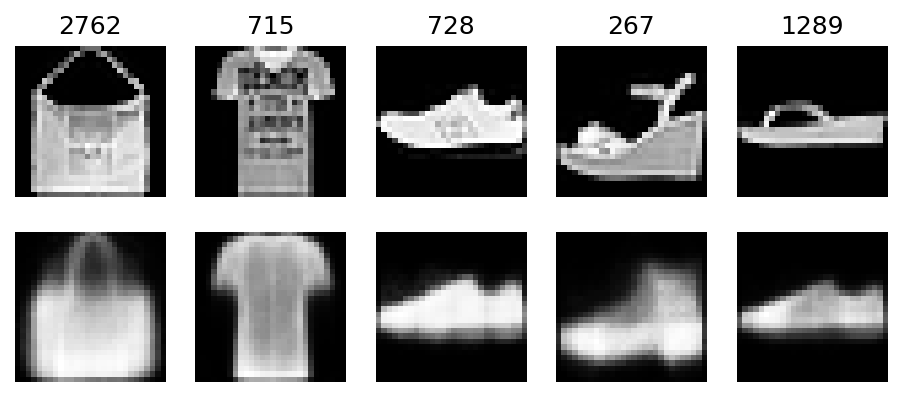

In [27]:
plot_reconstructions(sparse_l1_ae, index_list, X_valid)

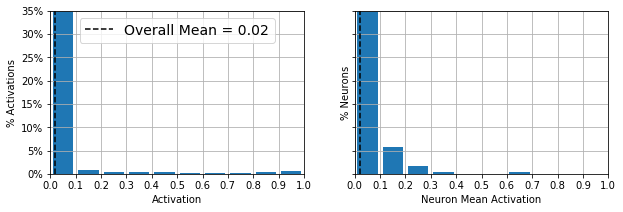

In [29]:
plot_activations_histogram(sparse_l1_encoder, height=0.35)
plt.show()

We will use KL Divergence to target the sparsity of 10%, rather than 0%

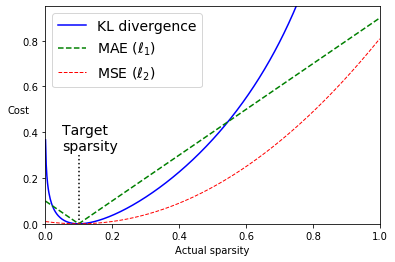

In [32]:
# plot the regulizers (from Geron book)
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])
plt.show()

In [33]:
# build custom regularizer for KL-Divergence
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [34]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 6s 103us/sample - loss: 0.4153 - rounded_accuracy: 0.8119 - val_loss: 0.3666 - val_rounded_accuracy: 0.8588
Epoch 2/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3535 - rounded_accuracy: 0.8762 - val_loss: 0.3398 - val_rounded_accuracy: 0.8863
Epoch 3/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3343 - rounded_accuracy: 0.8918 - val_loss: 0.3251 - val_rounded_accuracy: 0.8983
Epoch 4/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.3227 - rounded_accuracy: 0.9017 - val_loss: 0.3170 - val_rounded_accuracy: 0.9051
Epoch 5/10
55000/55000 [==============================] - 5s 87us/sample - loss: 0.3173 - rounded_accuracy: 0.9062 - val_loss: 0.3130 - val_rounded_accuracy: 0.9090
Epoch 6/10
55000/55000 [==============================] - 5s 86us/sample - loss: 0.3138 - rounded_accuracy: 0.9092 - val_loss

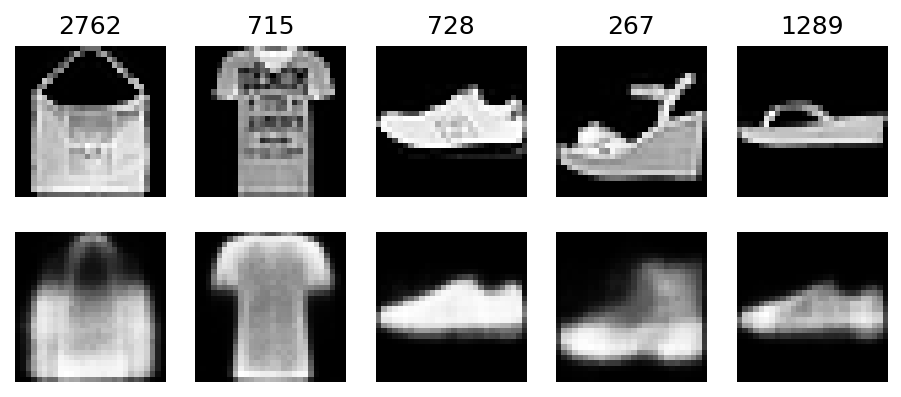

In [35]:
plot_reconstructions(sparse_kl_ae, index_list, X_valid)

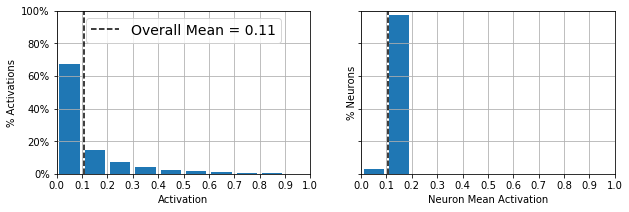

In [37]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()

Plot all three models beside each other for easy comparison.

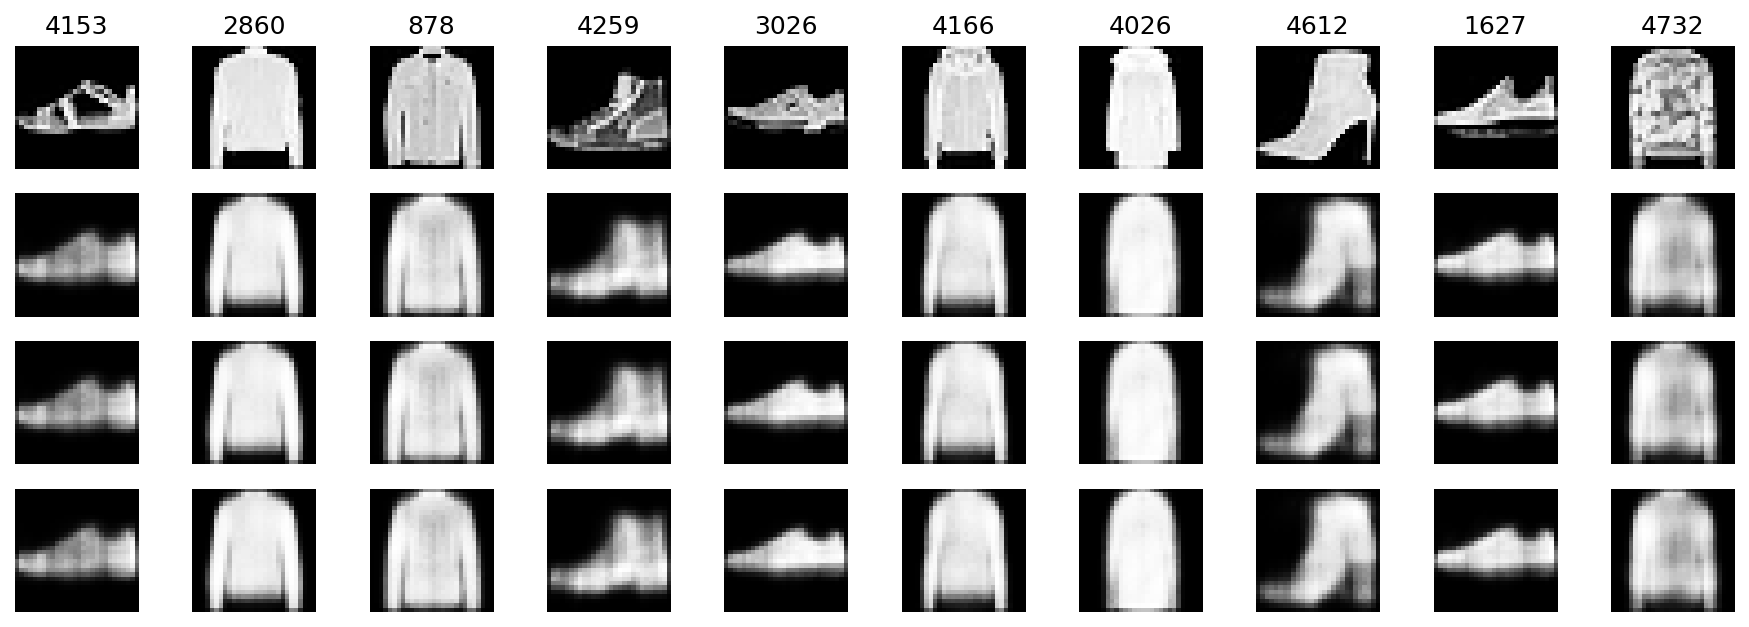

In [46]:
# plot the results
def plot_reconstructions_three_models(model1, model2, model3, index_list, X_valid): 
    reconstructions1 = model1.predict(X_valid)
    reconstructions2 = model1.predict(X_valid)
    reconstructions3 = model1.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(4, n_images,figsize=(n_images*1.5,5),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions1[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        axes[2][i].imshow(np.reshape(reconstructions2[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[2][i].axis('off')
        axes[3][i].imshow(np.reshape(reconstructions3[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[3][i].axis('off')
        
    plt.show()

import random
index_list = random.sample(range(0,len(X_valid)), 10)
plot_reconstructions_three_models(simple_ae, sparse_l1_ae, sparse_kl_ae, index_list, X_valid)